Karen Gong

Partner: Harrison Robel

PHYS 434 AA Lab 2

In [14]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')
hf.keys()
data = np.array(hf.get('data'))
data[:,0]
hf.close()

Problem 1 

In this problem we are looking at the data from a gamma-ray satellite orbiting in low Earth orbit. The satellite takes a reading of the number of particles detected every 100 milliseconds, and is in an approximately 90 minute orbit. When it is looking for gamma-ray bursts, virtually all of the particles detected are background cosmic rays.

1)Download the data from the course website (gammaray_lab4.h5), and import it into your working environment. The data has 4 columns and more than 25 million rows. The columns are time (in gps seconds), Solar phase (deg) showing the position of the sun relative to the orbit, Earth longitude (deg) giving the position of the spacecraft relative to the ground, and particle counts. Make a few plots, generally exploring your data and making sure you understand it. Give a high level description of the data features you see. Specifically comment on whether you see signal contamination in your data, and how you plan to build a background pdf().

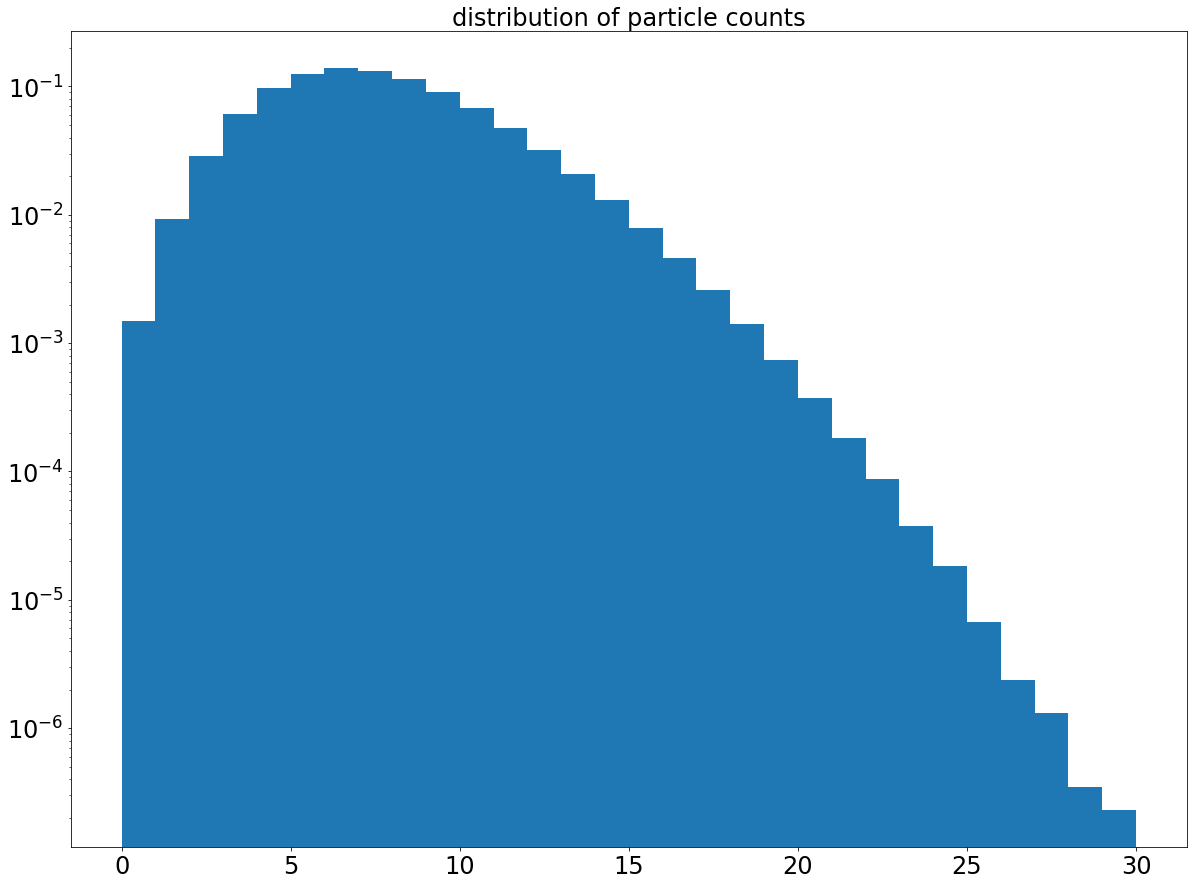

In [3]:
# COL 1: time (in gps seconds), COL 2: Solar phase (deg), COL 3: Earth longitude (deg), COL 4: gamma-ray counts

time = data[0,:]
solar = data[1,:]
longitude = data[2,:]
counts = data[3,:]

# distribution of particle counts
fig, ax = plt.subplots(1, 1)
ax.hist(counts,30, density=True)
plt.yscale("log")
plt.title("distribution of particle counts", size = 24)
plt.tick_params(labelsize = 24)
plt.show()

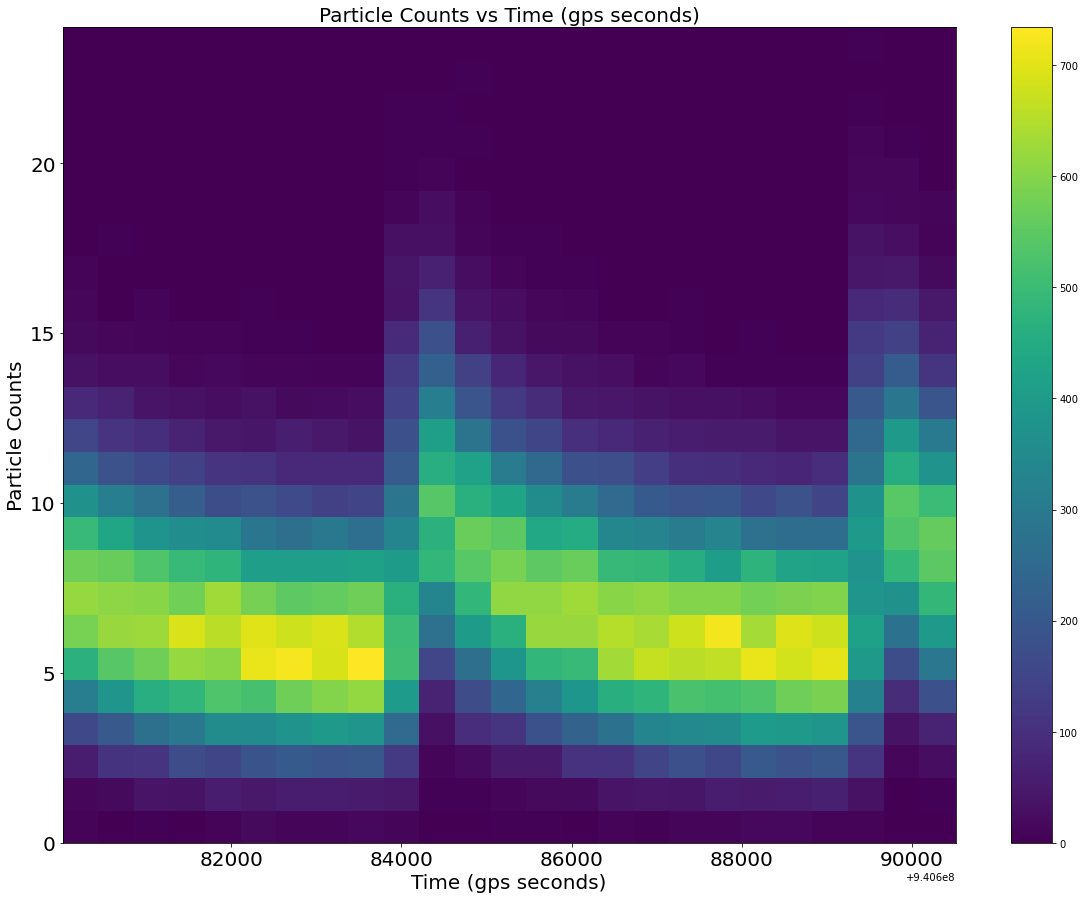

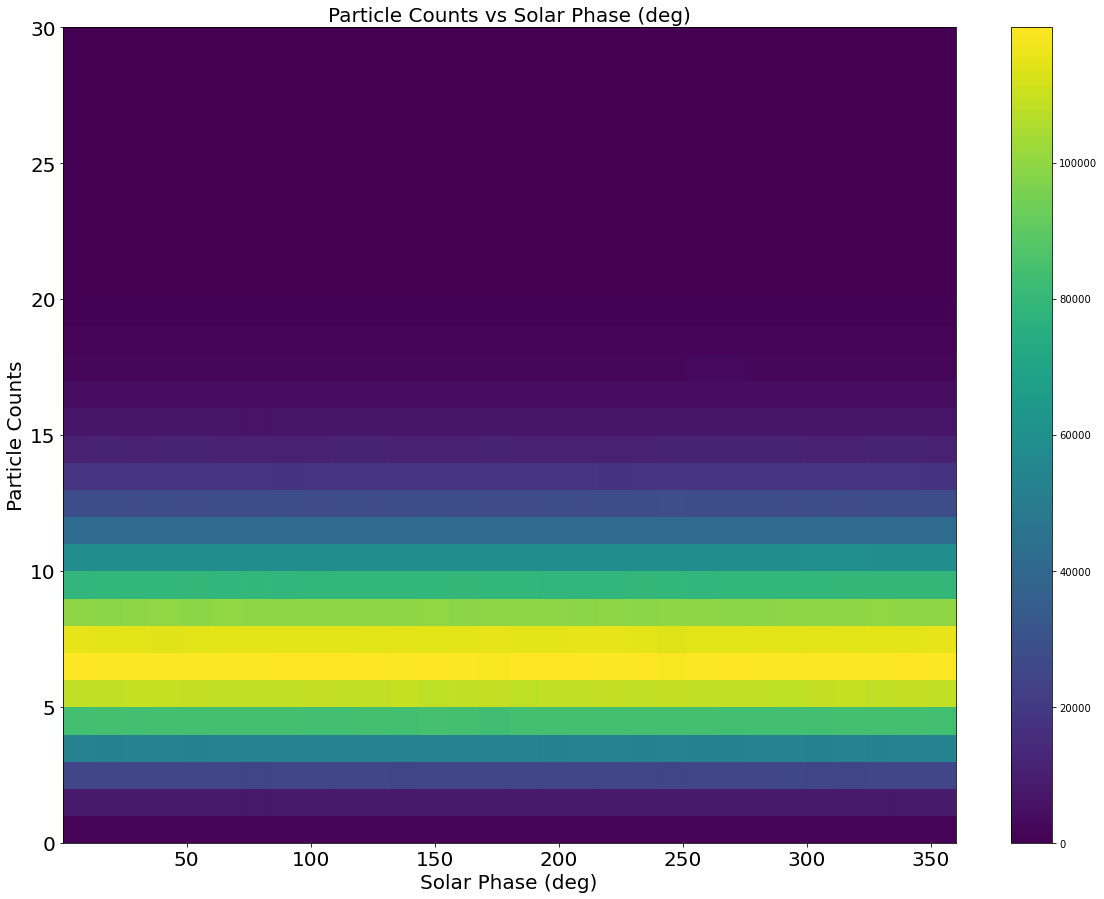

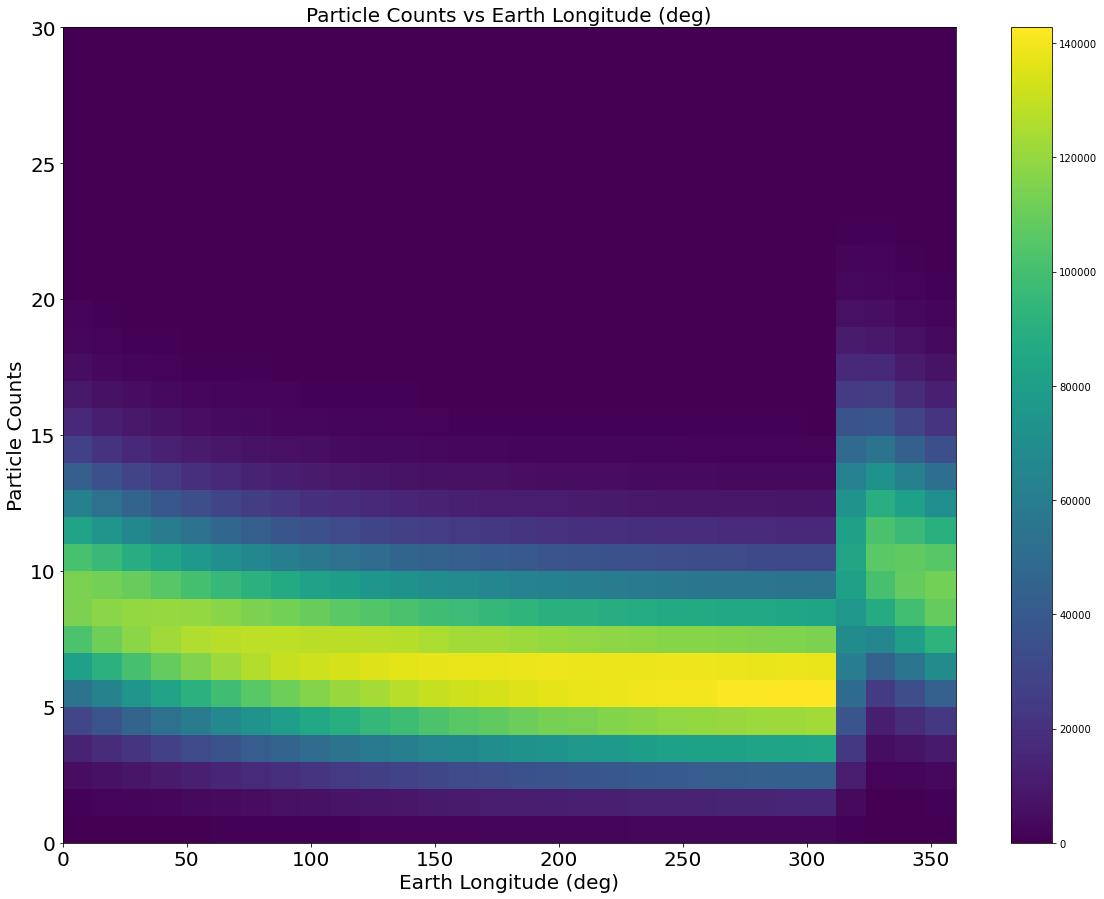

In [4]:
# this function plots the 2D histogram of two variables
def hist2d(x, y, xlabel, binsize):
    plt.hist2d(x, y, bins = binsize)
    plt.tick_params(labelsize = 20)
    plt.ylabel("Particle Counts", size = 20)
    plt.xlabel(xlabel, size = 20)
    plt.title("Particle Counts vs " + xlabel, size = 20)
    plt.colorbar()
    plt.show()
    
hist2d(time[:105001], counts[:105001], "Time (gps seconds)", 25)
hist2d(solar, counts, "Solar Phase (deg)", 30)
hist2d(longitude, counts, "Earth Longitude (deg)",30)

The particle counts distribution follows a Poisson distribution, as can be seen from the 1D histogram. This makes sense because the data counts are a discrete value so it should follow a discrete distribution. The following three graphs are 2D histograms of the three variables -- Solar phase, Earth longitude, and particle counts -- plotted against the time variable. The first of the graphs, Time vs Particle Counts, is zoomed in to see the first 105000 points. It can be seen that there is a wave-like fluctuation in the histogram. This may be due to some distortion in the frequencies of the particles or from the satellite itself. The second graph, Solar phase vs Particle Counts, does not seem to show any signs of signal contamination and it is constant with time. The final graph, which is Earth longitude vs Particle Counts, has an interesting effect. Firstly, unlike the other two 2D histograms, it's not constant as time goes on, it seems to follow some sort of decaying curve. This makes sense because the longitude is the position of the spacecraft relative to the ground dependent on time, that we already see is fluctuating from the first 2D histogram, so it is continuously changing. Another interesting effect is that there is a jump in longitude, somewhere between 300 and 325 gps seconds. It is especially strange because it seems to be that if that piece was sliced and shifted to the beginning of the histogram (at 0 gps seconds), the entire 2D histogram would have no jumps and be smooth. The jump in the data could be due to the various reasons, such a mistake on the telescope's part or the rate at which the particles were measured changed or anything else. 

To make a background PDF to fix the inconsistencies in the data set, we can take slices of the Earth longitude vs particle count data, every 1000 or so points. Then we can find the mean of those points to make a background distribution that limits the signal contamination.

2)The background is not consistent across the dataset. Find and describe as accurately as you can how the background changes.

The background is not consistent in the Earth longitude dataset. There is a periodic variation in time vs Earth longitude. The background seems to decay smoothly overall until about 310-320 gps seconds, where there is a sudden discontinuous jump in longitude. If the jump in longitude were moved to the beginning of the distribution, it would be a smooth distribution. 

3)Create a model for the background that includes time dependence, and explicitly compare your model to the data. How good is your model of the background?

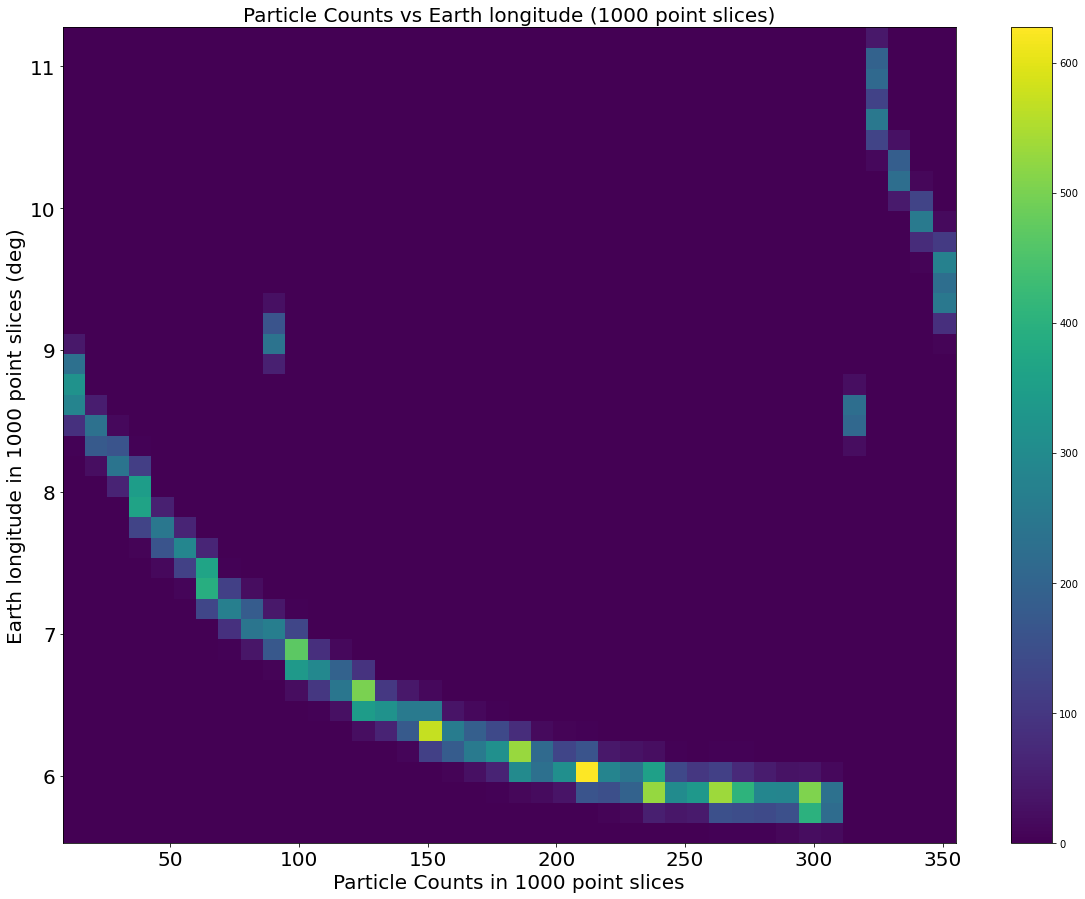

In [5]:
# this function finds the average of a certain number of rows (N: the size of the slice)
# given an array (myArray)
def sliceAvg(myArray, N):
    result = np.cumsum(myArray, 0)[N-1::N]/float(N)
    result[1:] = result[1:] - result[:-1]
    return result

newcounts = sliceAvg(counts, 1000)
elong = sliceAvg(longitude, 1000)

plt.hist2d(elong, newcounts, bins = 40)
plt.tick_params(labelsize = 20)
plt.xlabel("Particle Counts in 1000 point slices", size = 20)
plt.ylabel("Earth longitude in 1000 point slices (deg)", size = 20)
plt.title("Particle Counts vs Earth longitude (1000 point slices)", size = 20)
plt.colorbar()
plt.show()

As can be seen from the new 2D histogram, taking slices of the data creates a clear background of the Earth longitude, which is dependent on time. The model is created by averaging the values of every 1000 points (size of the slice). Essentially, it's determining how the average moves as time increases. The background still follows the slight decaying pattern as before, as well as the discontinuous jump in longitude around 310 degrees. The discontinuity is more obvious in the 100 point slices graph than in the original histogram. The pattern is clearer in the sliced graph, so it could be easier to solve for an equation that follows the shape of the graph. If we wanted the background to be even more precise, we could take smaller slices. 

4)Because the background varies, your discovery sensitivity threshold (how many particles you would need to see) also varies. What is the '5-sigma' threshold for a 100 millisecond GRB at different times?

In [6]:
#prob5sig = 1/3.5e6
prob5sigma = 1/3.5e6

# 100 millisecond GRB
grb = 100

#detection threshold near the beginning of the measurement
det1 = stats.poisson.ppf(1 - prob5sigma/grb, np.mean(counts[:10000]))
#print(det1)
sigma1 = stats.poisson.sf(det1, np.mean(counts[:10000])) * grb
print("Threshold near the beginning:", sigma1)

#detection threshold near middle of measurement
det2 = stats.poisson.ppf(1 - prob5sigma/grb, np.mean(counts[:2000000]))
#print(det2)
sigma2 = stats.poisson.sf(det2, np.mean(counts[:2000000])) * grb
print("Threshold near the middle:", sigma2)

#detection threshold near end of measurement
det3 = stats.poisson.ppf(1 - prob5sigma/grb, np.mean(counts[:25000000]))
#print(det3)
sigma3 = stats.poisson.sf(det3, np.mean(counts[:25000000])) * grb
print("Threshold near the end:", sigma3)


Threshold near the beginning: 7.392578000898934e-08
Threshold near the middle: 2.4394325059932963e-07
Threshold near the end: 2.4236400486238365e-07


Problem 2 

In this problem we are looking at a stack of 10 telescope images. We will be looking for a transient signal (something like a super novae that only appears in one image. The smallest pixel in an image could be a signal from a supernova so we need to create a background pdf that will allow us to see if there is signal contamination or something transient.

1)Download the data from images.h5. It is a stack of 10 square images, each 200 pixels on a side.

In [7]:
im = h5py.File('images.h5', 'r')
im.keys()
image = np.array(im.get('image1'))
stack = np.array(im.get('imagestack'))
im.close()

2)Explore the data. Is there signal contamination? Is the background time dependent? Is it consistent spatially? Develop a plan to calculate your background pdf().

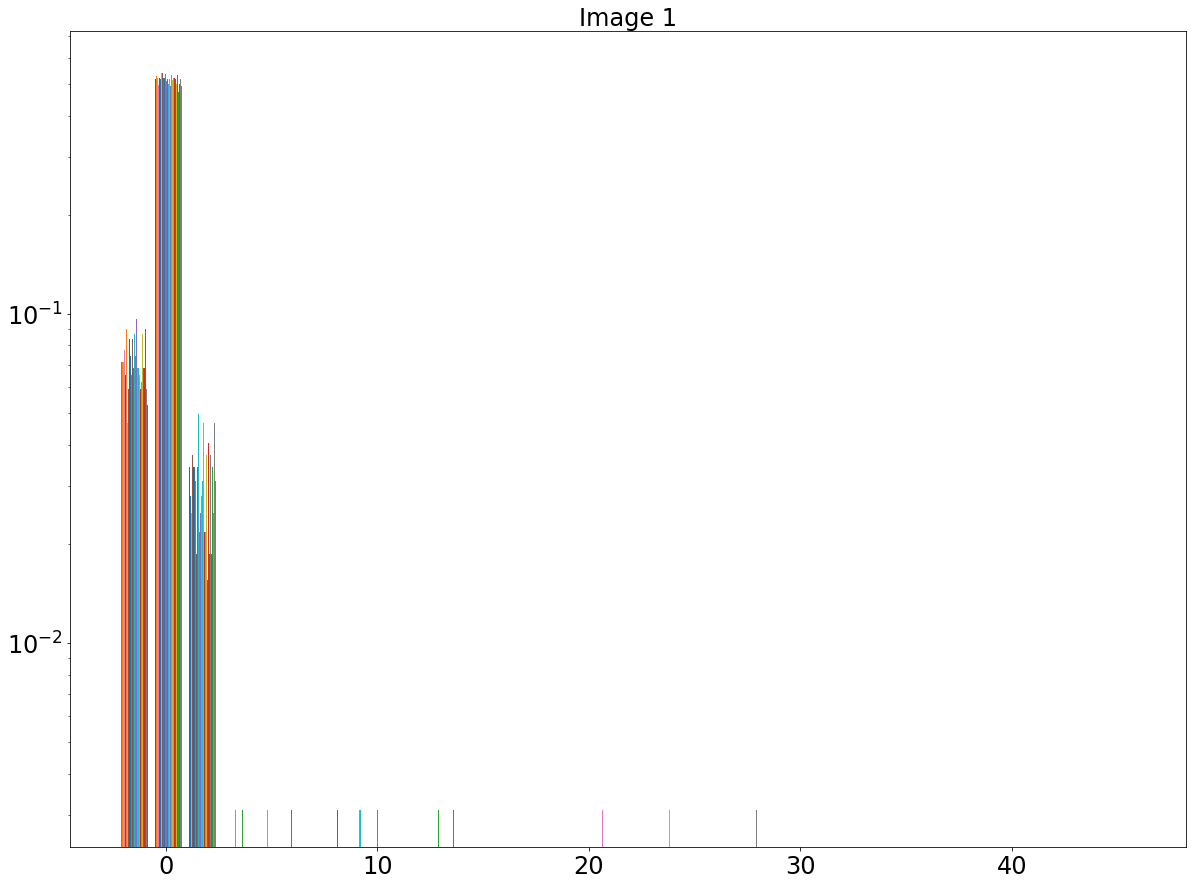

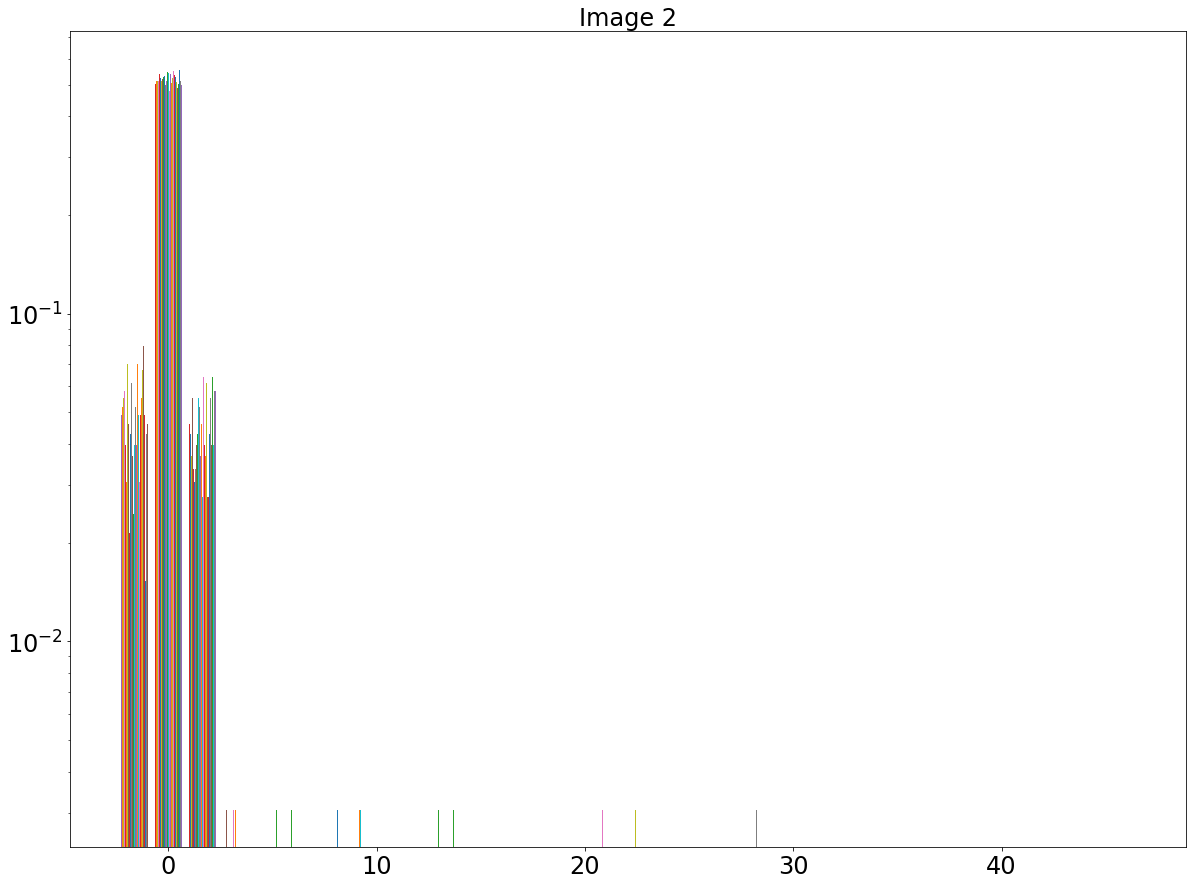

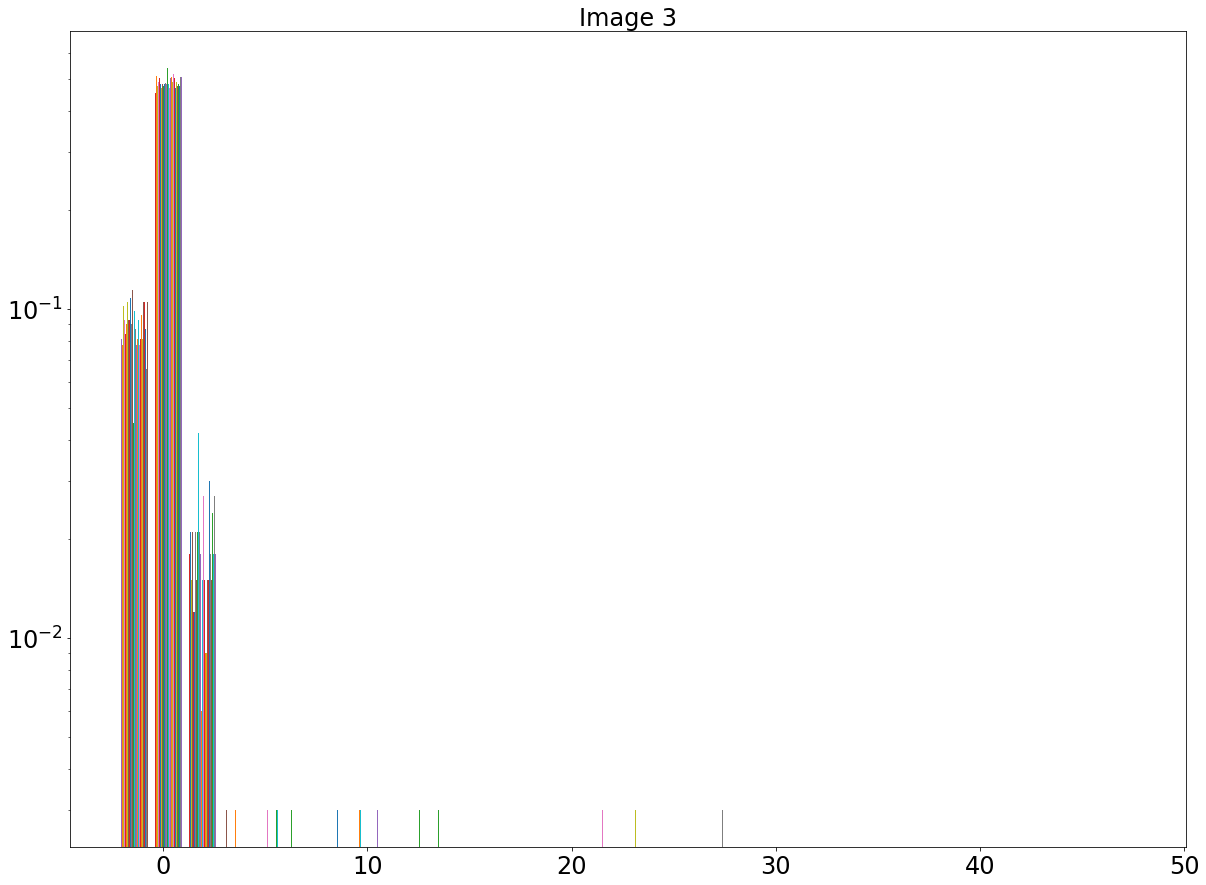

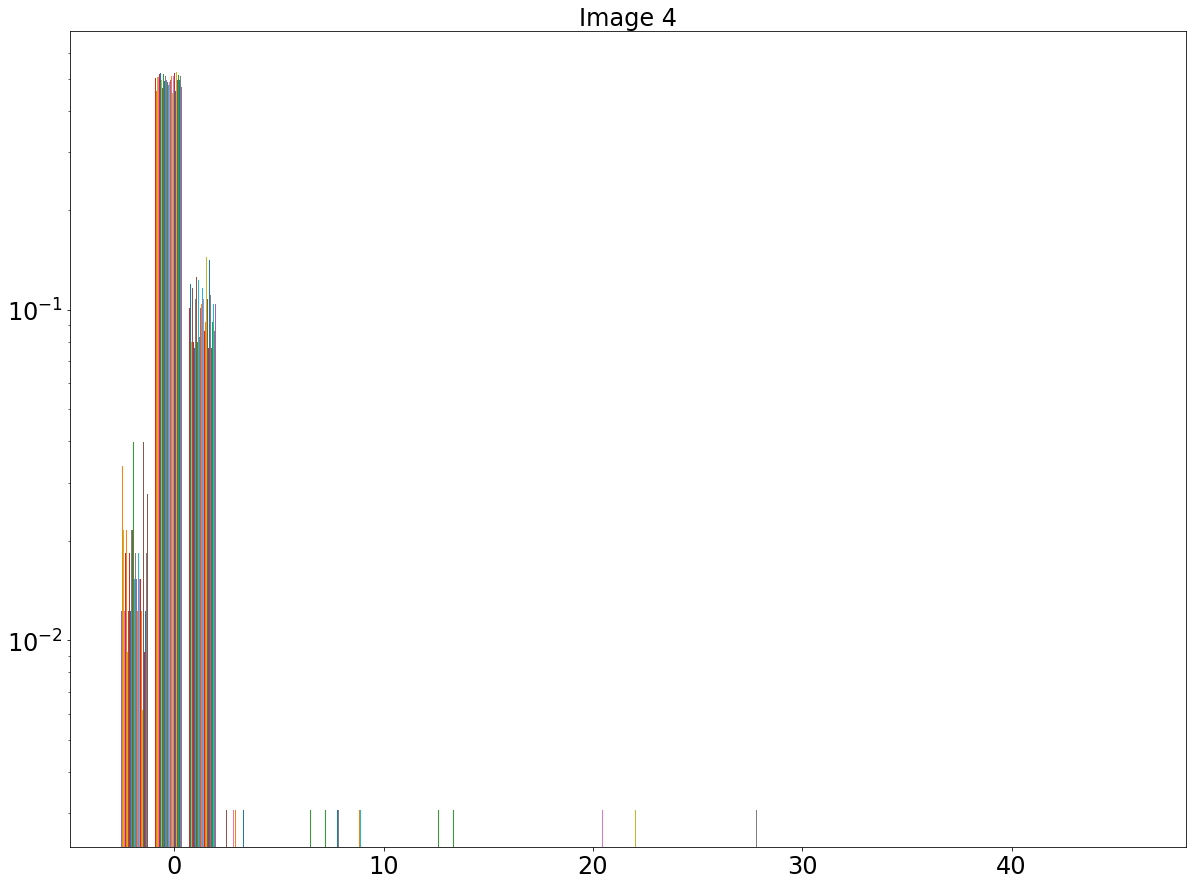

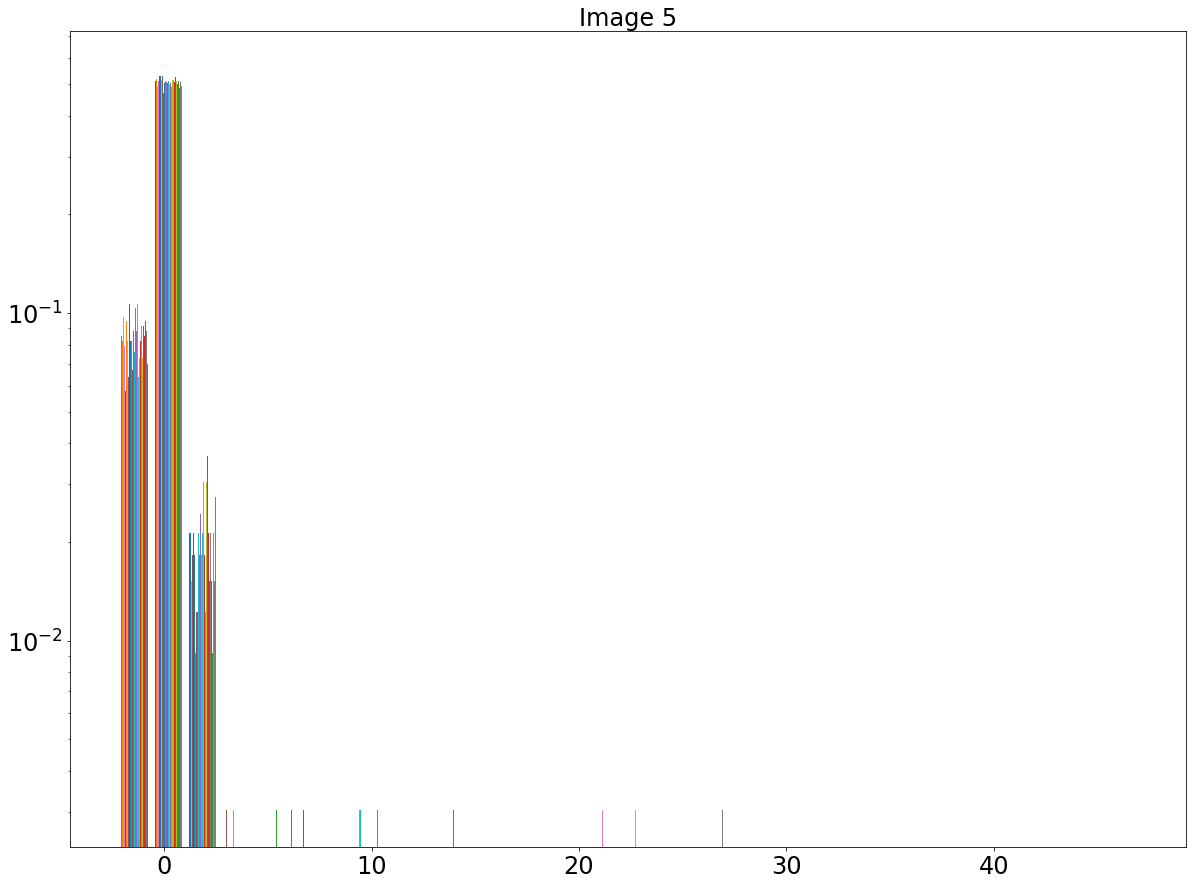

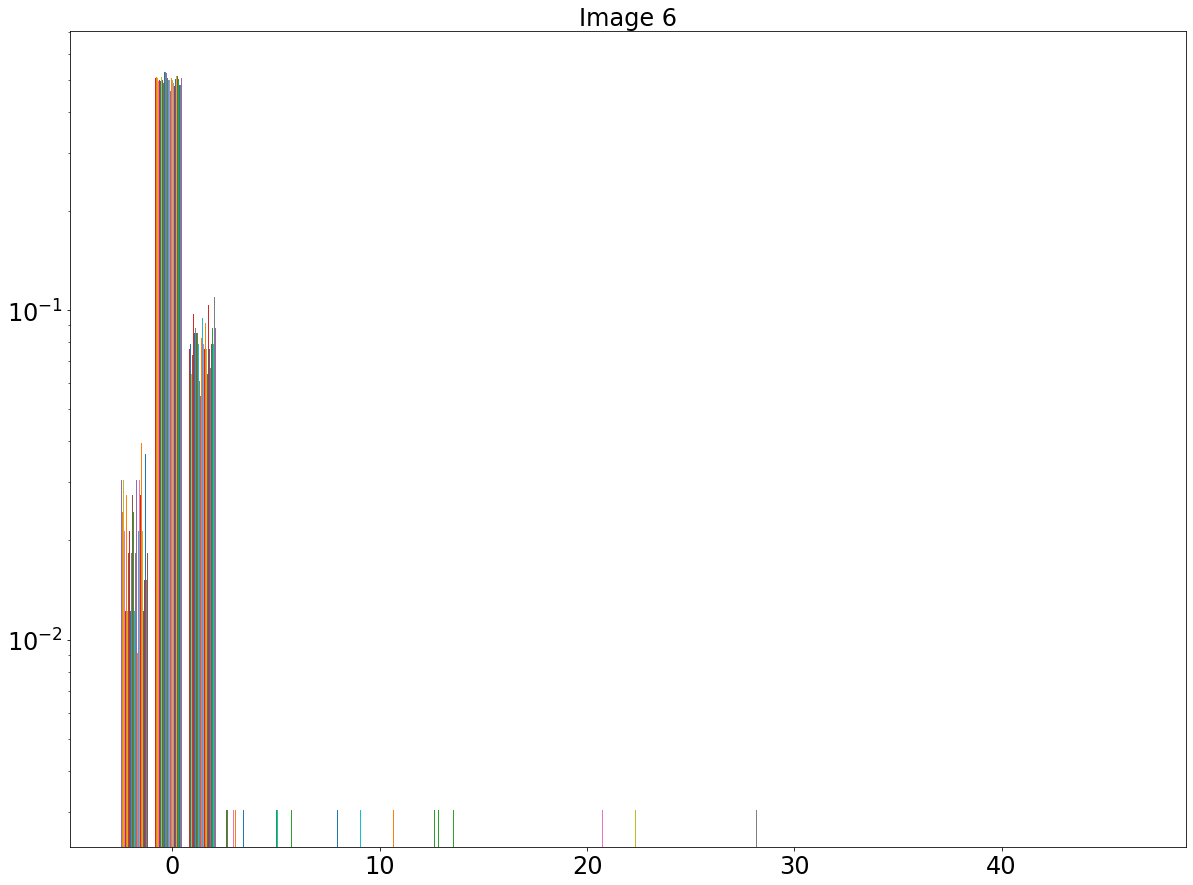

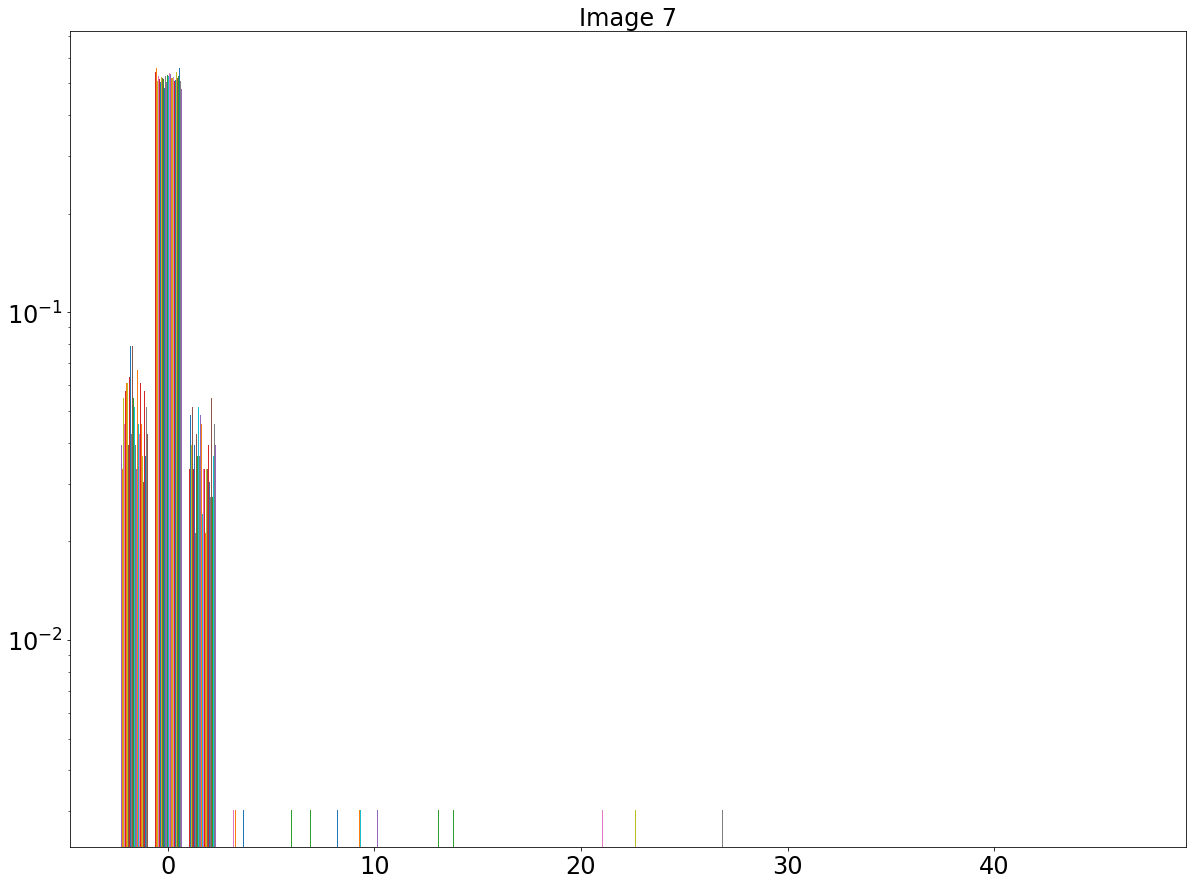

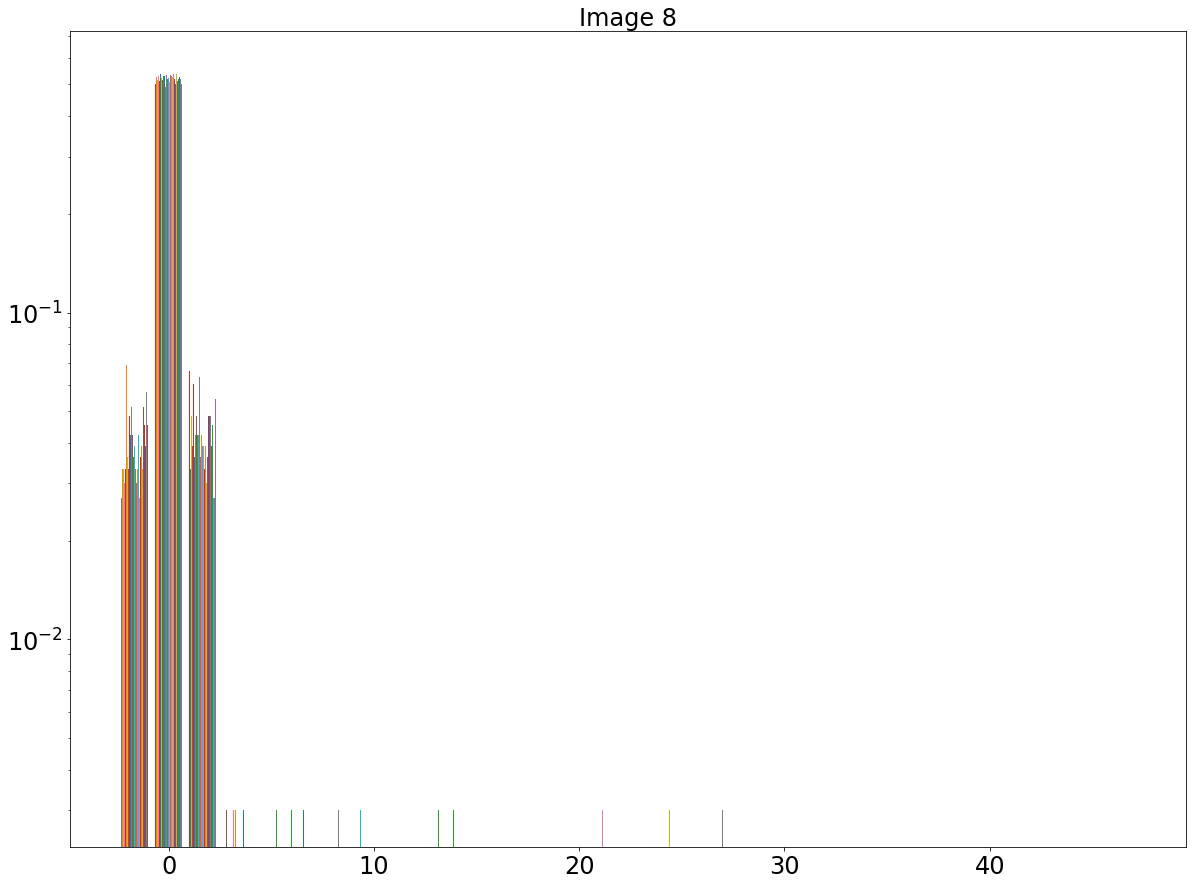

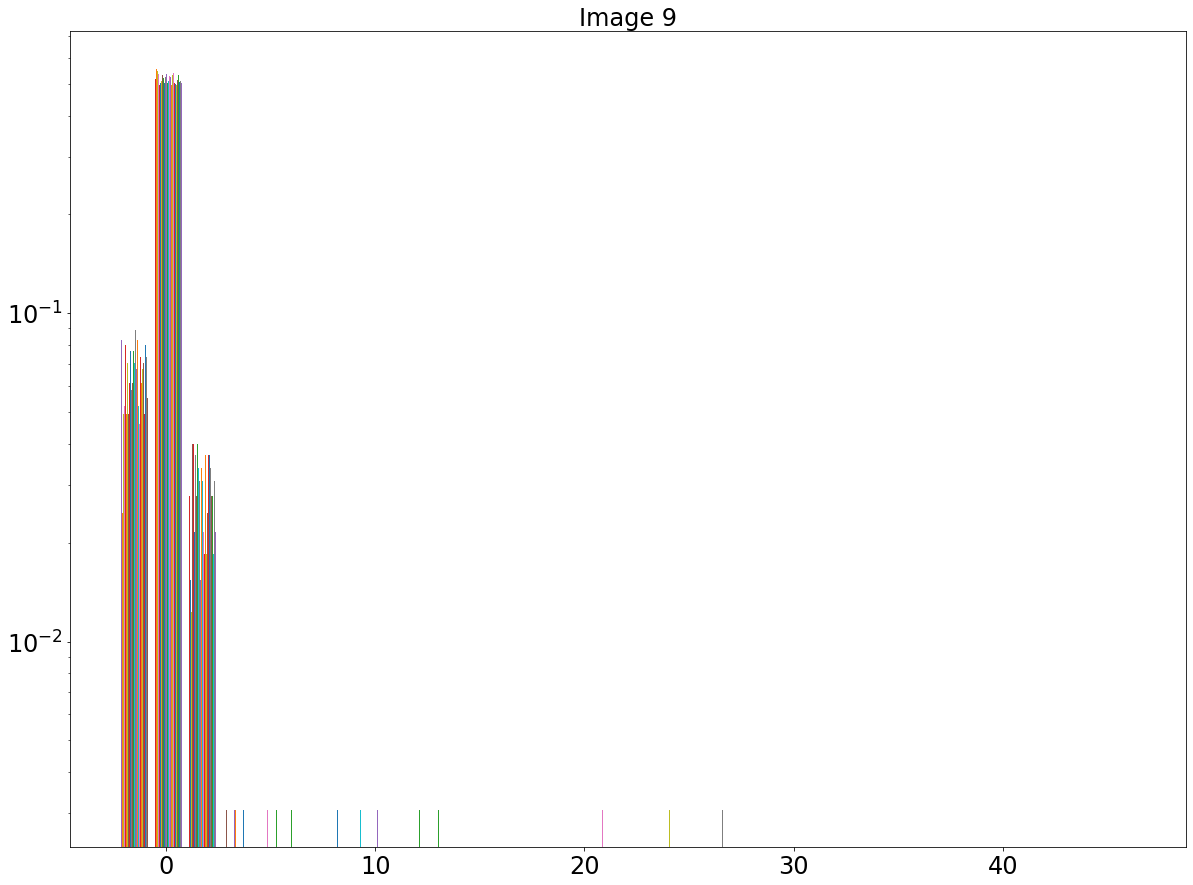

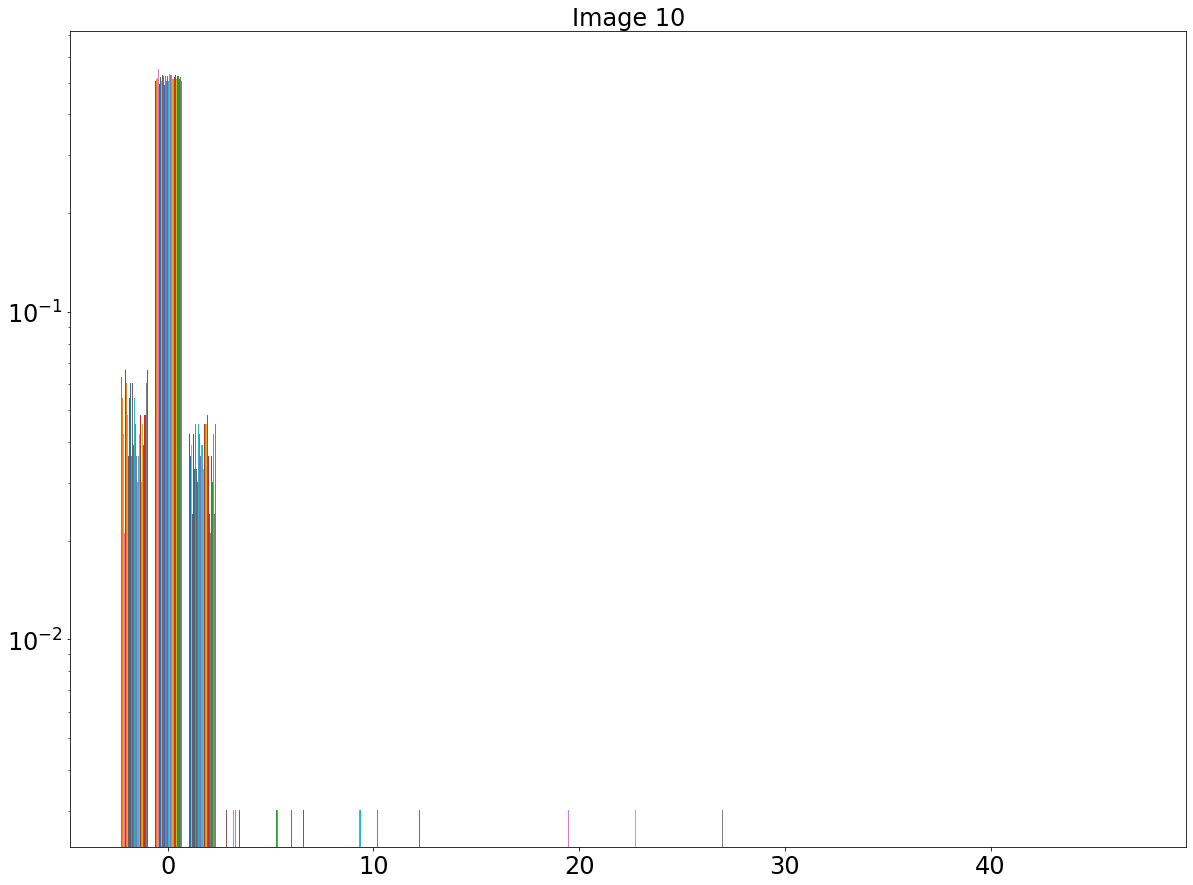

In [15]:
image1 = stack[:,:,0]
image2 = stack[:,:,1]
image3 = stack[:,:,2]
image4 = stack[:,:,3]
image5 = stack[:,:,4]
image6 = stack[:,:,5]
image7 = stack[:,:,6]
image8 = stack[:,:,7]
image9 = stack[:,:,8]
image10 = stack[:,:,9]

def plothist(image, title):
    fig, ax = plt.subplots(1, 1)
    ax.hist(image,30, density=True)
    plt.yscale("log")
    plt.title(title, size = 24)
    plt.tick_params(labelsize = 24)
    plt.show()

plothist(image1, "Image 1")
plothist(image2, "Image 2")
plothist(image3, "Image 3")
plothist(image4, "Image 4")
plothist(image5, "Image 5")
plothist(image6, "Image 6")
plothist(image7, "Image 7")
plothist(image8, "Image 8")
plothist(image9, "Image 9")
plothist(image10, "Image 10")

Above are the plots of each of the ten images from the stack of images. It can be seen that all the graphs have signal contamination, or noise, not within the main part of the distribution. These represent the stars captured in the images. The background should be Gaussian, as it is the same point in space at different times. The images are consistent spatially because the noise, which are the stars, are consistent in every image. Since the stars are in the same location across the images, we can subtract one image from another to remove the stars and reduce the noise.

3)Using your background distribution, hunt for your signal (either faint stars, or a transient). Describe what you find.

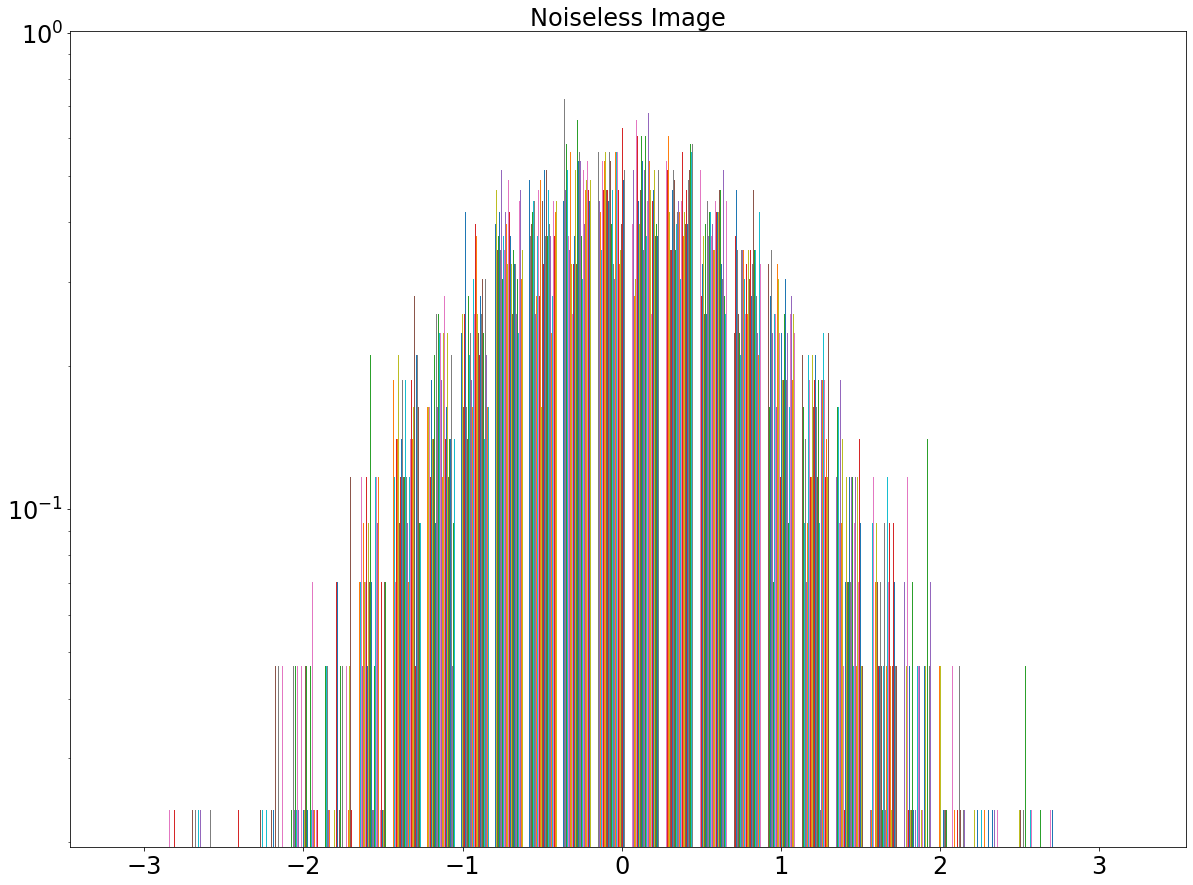

In [24]:
newimage = image1 - image2
fig, ax = plt.subplots(1, 1)
ax.hist(newimage,30, density=True)
plt.yscale("log")
plt.title("Noiseless Image", size = 24)
plt.tick_params(labelsize = 24)
plt.show()

In [46]:
prob5sigma = 1/3.5e6

#detection threshold
det = stats.norm.ppf(1 - prob5sigma, np.mean(newimage))
#print(det)
sigma = stats.norm.sf(det, np.mean(newimage))
print("Sigma:", sigma)

Sigma: 2.857142856749202e-07


To find something transient, like a supernova, we need to make sure that the background will produce a signal for a 5-sigma detection. Since the sigma value determined is much, much lower than the sigma value needed to be considered significant (5-sigma), there is no supernova detected the the first image. 

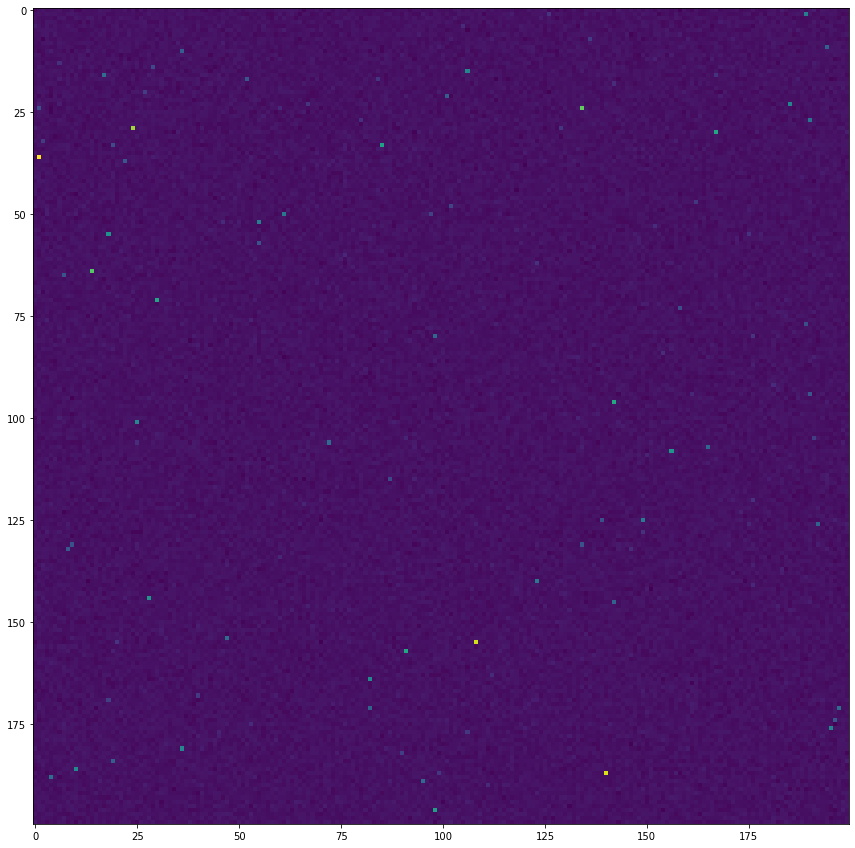

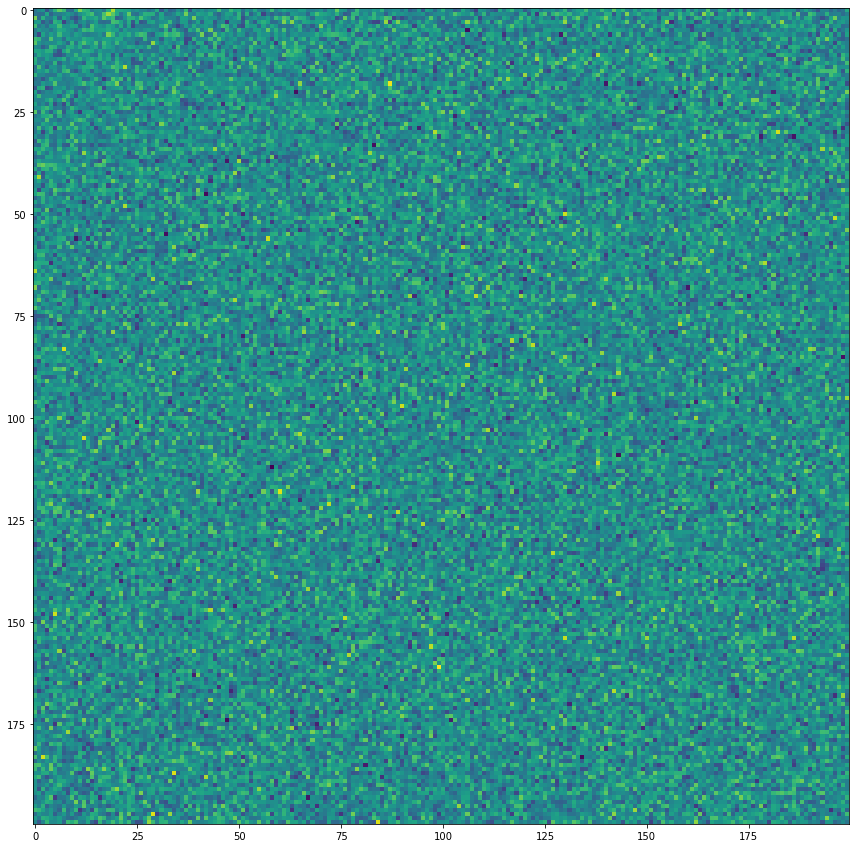

In [36]:
# first image data from stack displayed as an image
plt.imshow(image1)
# new image data displayed as an image 
plt.imshow(newimage)

4)You and your lab partner had different pdf(), but were using the same data. Explore why this is.

My partner and I had a different pdf but were using the same data because the way we determined our pdf differed. I subtracted images from one another to find my pdf, but my partner determined their pdf using the standard deviation of the dataset. Determining the pdf using different methods will result in different background pdfs. 